In [1]:
#Preamble
import tensorflow as tf
#enable Eager execution
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt


In [2]:
#Start Interactive Session
sess = tf.InteractiveSession()

def mTot(mass1,mass2):
    # Input tensor constants, outputs a tensor constant
    return tf.add(mass1,mass2)

def eta(mass1,mass2):
    #returns symetric mass in TensorFlow syntax
    #must input tensorflow constants
    M = mTot(mass1,mass2)
    
    eta_top = tf.multiply(mass1,mass2)
    eta_bottom = tf.square(tf.add(mass1,mass2))
    
    return tf.divide(eta_top,eta_bottom)

def mChirp(mass1,mass2):
    
    M = mTot(mass1,mass2)
    m_eta = eta(mass1,mass2)
        
    #Chirp mass is given by M*(eta^3/5)
    ChirpMass = tf.multiply(M,tf.pow(m_eta,(3/5)))
    
    return ChirpMass
    
def vParam(mTotal,frequencies,Order):
    
    piM = tf.multiply(mTotal,np.pi)
    v = tf.pow(tf.multiply(piM,frequencies),(1/3))
    
    return tf.pow(v,Order)
    
def phase_0PN(freq,mTot,mSym,t_c,phi_c):
    # returns the phase orders of the 0PN waveform
    # arguments are total mass, frequencies, symertric mass ratio, coelescence time & coalecencse phase
    
    #Equation in non-TensorFlow syntax is given as:
    #(3/128)*((np.pi*mTot*freq)**(-5/3))*(1/mSym)+(2*np.pi*freq*t_c) - phi_c
    
    #constants in equation
    c1 = tf.constant((3/128), name= "cnst1", dtype= tf.float32)
    c2 = tf.constant((2*np.pi*t_c),name = "coa_time_cnst", dtype = tf.float32)
    coa_phase = tf.constant(phi_c,name = "coa_phase", dtype = tf.float32)
    eta_r = tf.reciprocal(mSym)

    #multiply terms
    term1 = tf.multiply(c1,tf.multiply(vParam(mTot,freq,(-5)),eta_r))
                        
    #produce 2pift term
    term2 = tf.multiply(c2,freq)

    #add terms
    phases = tf.add(term1,tf.add(term2,(-phi_c)))
        
    return phases
                         
def amp_0PN(freq,ChirpMass,LuminosityDistance):
    #returns the amplitude of the 0PN waveform
    #arguments are chirp mass, luminosity distance and frequencies
                         
    term1 = tf.reciprocal(LuminosityDistance)
    term2 = tf.multiply(np.sqrt(5/24)*(np.pi**(-2/3)),tf.pow(ChirpMass,(5/6)))
    term3 = tf.pow(freq,(-7/6))
                         
    return tf.multiply(term1,tf.multiply(term2,term3))
                         
def TaylorFlow(mass1,mass2,frequencies,LuminosityDistance=40,t_c=-1.0,phi_c=np.pi):
    """TaylorFlow"""
                         
    #Define variable and constants in TensorFlow variables and constants    
    #Masses and frequencies are required inputs
    mass1 = tf.constant(mass1,name="mass1",dtype=tf.float32)
    mass2 = tf.constant(mass2,name="mass2",dtype=tf.float32)
    frequencies = tf.constant(frequencies,name= frequencies,dtype= tf.float32)
    #other constants                     
    L_D =  tf.constant((3.086e+22*LuminosityDistance),name="LuminosityDistance",dtype=tf.float32) 
    
    #get total mass,chirp mass and symetric mass ratio for use later in function
    M = mTot(mass1,mass2)
    etaMass = eta(mass1,mass2)
    ChirpMass = mChirp(mass1,mass2)
    
    #get phases at 0PN order
    phase = phase_0PN(frequencies,M,etaMass,t_c,phi_c)
    amp = amp_0PN(frequencies,ChirpMass,L_D)
    
    iphase = tf.multiply(tf.complex(0.,1.),tf.complex(phase,0.))
    waveform = tf.multiply(tf.complex(amp,0.),tf.exp(iphase))
    return waveform

def getFrequencies(mass1,mass2,f_low,df):

    M = mass1+mass2
    fISCO = 1/(6.**1.5*np.pi*M*4.93e-6)
    N = int(fISCO/df + 1)
    freq = np.linspace(f_low,fISCO,N,np.float64)
    return freq

In [3]:
m1 = 1.4
m2 = 1.8
f = getFrequencies(m1,m2,20,0.5)
waveform = TaylorFlow(m1,m2,f)
waveform = tf.abs(waveform)

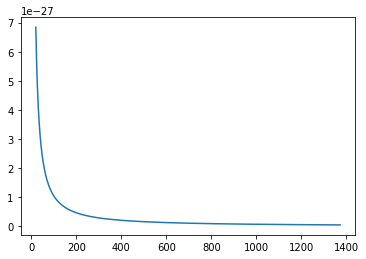

In [4]:
#print(waveform.numpy())
plt.plot(f,waveform.numpy())